In [24]:
import sys 
from scipy.interpolate import RegularGridInterpolator


sys.path.append("/users/tom/git/neon_blink_detection/")
sys.path.append("/users/tom/git/neon_blink_detection/src")

from src.features_calculator import create_grids
import numpy as np

from training.video_loader import video_loader
from src.helper import OfParams, AugParams
of_params = OfParams()
aug_params = AugParams()

clip_name = "1004-2022-12-14-13-14-14-c8a509b9"

of_params = OfParams(n_layers=3, layer_interval=7, average=False, img_shape=(64, 64), grid_size=4, step_size=5, window_size=11, stop_steps=3)

rec = video_loader(of_params, aug_params)

rec._load(clip_name, bg_ratio=3, augment=False)


In [38]:
feature_array, all_timestamps, clip_transitions = rec._load_features(
            clip_name, rec._of_params)

# Add random sampling of some indicies

n_clips = clip_transitions.shape[0] + 1
clip_feature_array = np.split(feature_array, clip_transitions + 1, axis=0)
clip_timestamps = np.split(all_timestamps, clip_transitions + 1, axis=0)

# only take y direction
feature_array = clip_feature_array[0][:, :, 1]
timestamps = clip_timestamps[0]
t = (timestamps - timestamps[0]) / 1e9

of_left = np.reshape(feature_array[:, :400], (-1,20,20))
of_right = np.reshape(feature_array[:, 400:], (-1,20,20))

In [ ]:
import typing as T

def new_concatenate_features(
    feature_array: np.ndarray, of_params: OfParams, indices: np.ndarray = None
) -> np.ndarray:
    
    def get_layers(n, layer_interval):
        return np.arange(-(n // 2), (n + 1) // 2) * layer_interval
    
    interp_left, interp_right = _create_interpolater(feature_array)
    
    layer_interval = of_params.layer_interval / 200 # sampling rate to convert to ms

    n_frame = len(feature_array)

    if indices is None:
        indices = np.arange(n_frame) / 200

    n_grids = of_params.grid_size * of_params.grid_size * 2
    layers = get_layers(of_params.n_layers, layer_interval)

    indices_layers = np.array([[indices + i] for i in layers]).reshape(len(layers), -1)
    indices_layers = np.clip(indices_layers, 0, len(feature_array) - 1)

    features_left = np.concatenate([interpolate_spacetime(interp_left, indices, grid_size=of_params.grid_size).reshape(-1, of_params.grid_size**2) for indices in indices_layers], axis=-1)

    features_right = np.concatenate([interpolate_spacetime(interp_right, indices, grid_size=of_params.grid_size).reshape(-1, of_params.grid_size**2) for indices in indices_layers], axis=-1)

    return np.concatenate((features_left, features_right), axis=-1)

def _create_interpolater(feature_array: np.ndarray, grid_size=20):

    length = grid_size ** 2

    of_left = np.reshape(feature_array[:, :length], (-1, grid_size, grid_size))
    of_right = np.reshape(feature_array[:, length:], (-1, grid_size, grid_size))

    x = np.linspace(0, 64, grid_size + 2, dtype=np.float32)[1:-1]
    y = np.linspace(0, 64, grid_size + 2, dtype=np.float32)[1:-1]

    interpolator_left = RegularGridInterpolator((t, x, y), of_left, bounds_error=False, fill_value=None, method="linear")
    
    interpolator_right = RegularGridInterpolator((t, x, y), of_right, bounds_error=False, fill_value=None, method="linear")

    return interpolator_left, interpolator_right


def interpolate_spacetime(interpolator, time_points: T.List[int], grid_size: int):
    
    x = np.linspace(0, 64, grid_size + 2, dtype=np.float32)[1:-1]
    y = np.linspace(0, 64, grid_size + 2, dtype=np.float32)[1:-1]

    tt, xx, yy = np.meshgrid(time_points, x, y)

    txy_grid = np.concatenate((tt.reshape(-1, 1), xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)
    
    return interpolator(txy_grid).reshape(grid_size, len(time_points), grid_size).transpose(1, 0, 2)



**Interpolate to 50x50 grid for 3 points in time**

*Plot result*

Text(0.5, 1.0, 'Original')

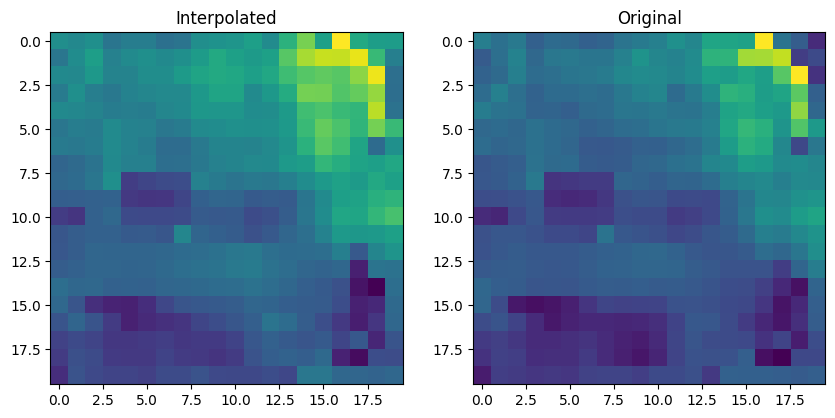

In [19]:
import matplotlib.pyplot as plt

interp_left, interp_right = _create_interpolater(feature_array)

of_interp = interpolate_spacetime(interp_left, 5.5*t[1:7], grid_size=20)

f, ax = plt.subplots(1, 5, figsize=(10, 5))

ax[0].imshow(of_interp[0,:, :])
ax[0].set_title("Interpolated")
                
ax[1].imshow(of_left[5, :, :])
ax[1].set_title("Original")


In [22]:
print(5.5*t[1:7])

t[5:12]

[0.0275 0.055  0.0825 0.11   0.1375 0.165 ]


array([0.025   , 0.03    , 0.035   , 0.04    , 0.045125, 0.050125,
       0.055125])

In [291]:

n_layers = rec._of_params.n_layers
t_layer_interval = rec._of_params.layer_interval / 200

n_frame = len(feature_array)
indices = t
n_grids = of_params.grid_size * of_params.grid_size * 2
layers = get_layers(of_params.n_layers, t_layer_interval)

indices_layers = np.array([[indices + i] for i in layers]).reshape(len(layers), -1)
indices_layers = np.clip(indices_layers, 0, len(feature_array) - 1)

features = np.concatenate([space_time_grid(interpolator_left, indices, grid_size=of_params.grid_size).reshape(-1, of_params.grid_size**2) for indices in indices_layers], axis=-1)

n_features = (
        of_params.n_layers if of_params.average else of_params.n_layers * n_grids
    )



In [293]:
of_params

OfParams(n_layers=3, layer_interval=7, average=False, img_shape=(64, 64), grid_size=4, step_size=5, window_size=11, stop_steps=3)

In [10]:
interp_left, interp_right = _create_interpolater(feature_array)



(8619, 96)

(8619, 96)

In [58]:
def concatenate_features(
    feature_array: np.ndarray, of_params: OfParams, indices: np.ndarray = None
) -> np.ndarray:
    def get_layers(n, layer_interval):
        return np.arange(-(n // 2), (n + 1) // 2) * layer_interval


    features = np.concatenate(
        [feature_array_y[indices] for indices in indices_layers], axis=1
    )
    n_features = (
        of_params.n_layers if of_params.average else of_params.n_layers * n_grids
    )
    # if features.shape != (len(indices), n_features):
    #     raise RuntimeError(
    #         f"feature shape should be {(len(indices), n_features)}, but get {features.shape}"
    #     )
    return features

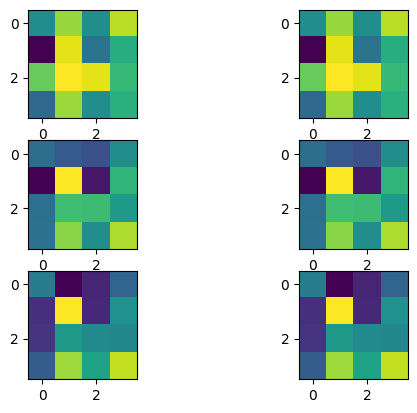

In [64]:
iframe = 2000

grid_size = 6 # grid_size we want to interpolate to
p_grid = create_grids((64,64), grid_size, 0)
time_ = t[iframe] # timestamp belonging to the frame
t_p_grid  = np.concatenate((time_ * np.ones((p_grid.shape[0],1)), p_grid), axis=1) 
# of_interp = np.reshape(interpolator_left(t_p_grid),(grid_size, grid_size))

p_grid.shape
interp = interpolator_left(t_p_grid).reshape(grid_size-2, grid_size-2, 6)

import matplotlib.pyplot as plt
f, ax = plt.subplots(3, 2)
ax[0, 0].imshow(interp[:, :, 0])
ax[0, 1].imshow(features_per_layer[iframe, :, :, 0].transpose())
ax[1, 0].imshow(interp[:, :, 2])
ax[1, 1].imshow(features_per_layer[iframe, :, :, 2].transpose())
ax[2, 0].imshow(interp[:, :, 4])
ax[2, 1].imshow(features_per_layer[iframe, :, :, 4].transpose())


In [16]:
features_per_layer.shape

(43284, 4, 4, 6)

In [33]:
fea

array([200., 200., 200., 200., 200., 200.])

In [84]:
features_per_layer.shape

(37145, 4, 4, 6)

In [117]:
x, y = np.array([-2, 0, 4, 6]), np.array([-2, 0, 2, 5])

def ff(x, y):
    return x**2 + y**2

xg, yg = np.meshgrid(x, y, indexing='ij')
data = ff(xg, yg)
data

interp = RegularGridInterpolator((x, y), data,
                                 bounds_error=False, fill_value=None)
# import matplotlib.pyplot as plt
# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')
# ax.scatter(xg.ravel(), yg.ravel(), data.ravel(),
#            s=60, c='k', label='data')

In [37]:
timestamps = rec._get_timestamps("1004-2022-12-14-13-14-14-c8a509b9")
t = (t - t[0])

array([0.000000e+00, 5.000000e-30, 1.000000e-29, ..., 4.312539e-26,
       4.313039e-26, 4.313539e-26])

In [124]:
data = np.random.rand(10,10)

x = np.linspace(0, 10, 10 + 2, dtype=np.float32)[1:-1]
y = np.linspace(0, 10, 10 + 2, dtype=np.float32)[1:-1]

interp = RegularGridInterpolator((x, y), data, bounds_error=False, fill_value=None)



array(0.31941931)

In [29]:
# new_features = rec.new_features["1004-2022-12-14-13-14-14-c8a509b9"]
# old_features = rec.all_features["1004-2022-12-14-13-14-14-c8a509b9"]

rec.all_features["1004-2022-12-14-13-14-14-c8a509b9"]

array([[ 0.        ,  0.        ,  0.        , ...,  0.52988525,
         0.12120346, -0.19180679],
       [ 0.        ,  0.        ,  0.        , ...,  0.51437012,
         0.09928513, -0.16889191],
       [ 0.        ,  0.        ,  0.        , ...,  0.45018599,
         0.09263438, -0.32169029],
       ...,
       [ 0.11040108,  0.32707844, -0.38693764, ...,  0.77025223,
         0.45096512,  2.63846664],
       [ 0.58421371, -0.5883371 , -1.40084953, ...,  1.27601028,
         0.77690796,  2.74469543],
       [ 0.564589  , -0.56247597, -1.91046638, ...,  1.78176834,
         1.1028508 ,  2.85092422]])

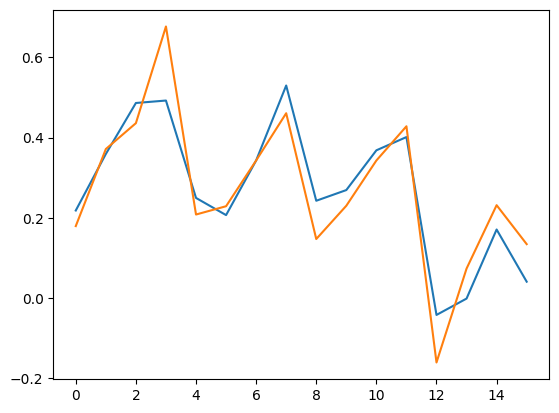

In [18]:
import matplotlib.pyplot as plt
plt.plot(new_features[10, 0:16])
plt.plot(old_features[10, 0:16])

In [40]:
t[0:10]

array([0.      , 0.005   , 0.01    , 0.015   , 0.02    , 0.025   ,
       0.03    , 0.035   , 0.04    , 0.045125])